# Cavity-QED in the dispersive regime with eHe

Author: K. V. Shulga (kirill-shulga@oist.jp)

In [1]:
%matplotlib inline

In [190]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from qutip import *
import pickle
import scipy.sparse as sp

from scipy.sparse.linalg import eigsh
from scipy.constants import e, h, Boltzmann, hbar, k, m_e, epsilon_0, mu_0
from scipy.sparse import csr_matrix
from scipy.sparse import spdiags, diags
from scipy.fft import dct, idct, dst, idst
import scipy.linalg as scl

from ipywidgets import IntProgress
from IPython.display import display
import time

# Introduction

The Rabi model was introduced by Isidor Rabi in 1936 to describe the semiclassical coupling of a two-level
atom with a classical monochromatic electromagnetic wave. In its fully quantized version, the model is given by the
Hamiltonian

### $H_R =\hbar(\Omega/2)\sigma_z+ \hbar\omega a^\dagger a + \hbar g \sigma_x(a^\dagger+a)$,

which is nowadays known as the quantum Rabi model. Here $\Omega$ and $\omega$ are the frequencies of the atomic transition and the electromagnetic field, respectively, and $g$ is the light-matter coupling strength. $\sigma_{x,z}$ are Pauli matrices describing the atomic spin, while $a$ and $a^\dagger$ are the annihilation and creation operators of the bosonic field mode, respectively.

### Problem parameters

Physical constants definition (in SI units)

In [206]:
from scipy.constants import e, h, hbar, k, m_e, epsilon_0, mu_0

In [278]:
hb   = hbar                            # Plank constant [Js], or 4.136e-15 [eV s]
qe   = e                               # elementary charge [C]
me   = m_e                             # electron mass [kg] or 0.5109 [MeV]

If $\Omega-\omega \approx \Omega+\omega$ the RWA breaks down.

There are two small parameters $\Lambda = g/(\Omega+\omega)$ and $\lambda = g/(\Omega-\omega)$. 

In [280]:
# All frequencies in GHz
wr = 5.8*2*np.pi                                                          # resonator frequency
wq = 140*2*np.pi                                                          # qubit frequency
g  = 1.5*2*np.pi                                                          # coupling strength
#print('Landau frequency:', wr/2/np.pi, 'GHz')
#print('Rydberg frequency:', wq/2/np.pi, 'GHz')
delta = wq - wr
Delta = wq + wr
lamb = g/delta
Lamb = g/Delta

chi = g**2/(wq - wr)
mu  = g**2/(wq + wr)

print('Coupling constant:', g/2/np.pi, 'GHz')
print('Dispersive shift:', chi*10**3/2/np.pi, 'MHz')
print('Bloch-Siegert shift:', mu*10**3/2/np.pi, 'MHz')

Coupling constant: 1.5 GHz
Dispersive shift: 16.766020864381524 MHz
Bloch-Siegert shift: 15.432098765432098 MHz


The terms $(a^\dagger\sigma_+ + a\sigma_-)$ in the Rabi Hamiltonian can be treated as a perturbation and eliminated via the unitary transformation:

$U_{BS} = exp(\Lambda a\sigma_- − \Lambda a^\dagger\sigma_+).$

Transforming the Rabi Hamiltonian with $U_{BS}$ gives

$H_q + H'_{qr} + H'_{r} + O(2)$,

where

$H'_{qr} = \hbar g (\sigma_+ a + a^\dagger\sigma_-)$

$H'_{r} = \hbar(\omega + g\Lambda\sigma_z)(a^\dagger a + \frac{1}{2})$

The shift $g\Lambda\sigma_z$ in the cavity resonance is known as the BlochSiegert shift.

The Hamiltonian of the qubit-resonator subsystem is of the Jaynes-Cummings form. It is possible to diagonalize it. 

The dispersive transform $U_{d} = exp(-\lambda \sigma_+ a + \lambda a^\dagger\sigma_-).$ 
 
Applying the transform yields

$H''_{r} = \hbar(\omega + g\Lambda\sigma_z + g\lambda\sigma_z)(a^\dagger a + \frac{1}{2}) = \hbar(\omega + (\chi+\mu)\sigma_z)(a^\dagger a + \frac{1}{2})$,

where $\chi = g^2/(\Omega-\omega)$ and $\mu = g^2/(\Omega+\omega)$ are dispersive and Bloch-Siegert shifts respectively.

In [281]:
NN = 12

# cavity operators
a = tensor(destroy(NN), qeye(2))
nc = a.dag() * a
xc = a + a.dag()

# atomic operators
sm = tensor(qeye(NN), destroy(2))
sz = tensor(qeye(NN), sigmaz())
sx = tensor(qeye(NN), sigmax())
nq = sm.dag() * sm
xq = sm + sm.dag()

I = tensor(qeye(NN), qeye(2))

collapse operators

In [282]:
g1 = 0.002        # relaxation rate
g2 = 0.001        # dephasing rate
n_th = 0.1       # bath temperature

##----------------------------------------------------

c_ops = []
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm)
c_ops.append(np.sqrt(g1 * n_th) * sm.trans().conj())
c_ops.append(np.sqrt(g2) * sz)

In [283]:
# dispersive hamiltonian
H = wr * (a.dag() * a + I/2.0) + (wq / 2.0) * sz + (chi+mu) * (a.dag() * a + I/2) * sz

Try different initial state of the resonator, and see how the spectrum further down in the notebook reflects the photon distribution chosen here.

In [315]:
psi0 = tensor(coherent(NN, np.sqrt(4)), (basis(2,0)+basis(2,1)).unit())
#psi0 = tensor((coherent(NN, np.sqrt(4)) + coherent(NN, np.sqrt(0))), (basis(2,0)+basis(2,1)).unit())
#psi0 = tensor(coherent(NN, np.sqrt(2)), (basis(2,0)+basis(2,1)).unit())
#psi0 = tensor(coherent(NN, np.sqrt(4)), basis(2,1))

### Time evolution

In [316]:
tlist = np.linspace(0, 250, 1000)

In [317]:
res = mesolve(H, psi0, tlist, [], [], options=Odeoptions(nsteps=5000))

### Excitation numbers

We can see that the systems do not exchange any energy, because of they are off resonance with each other.

In [318]:
nc_list = expect(nc, res.states)
nq_list = expect(nq, res.states)

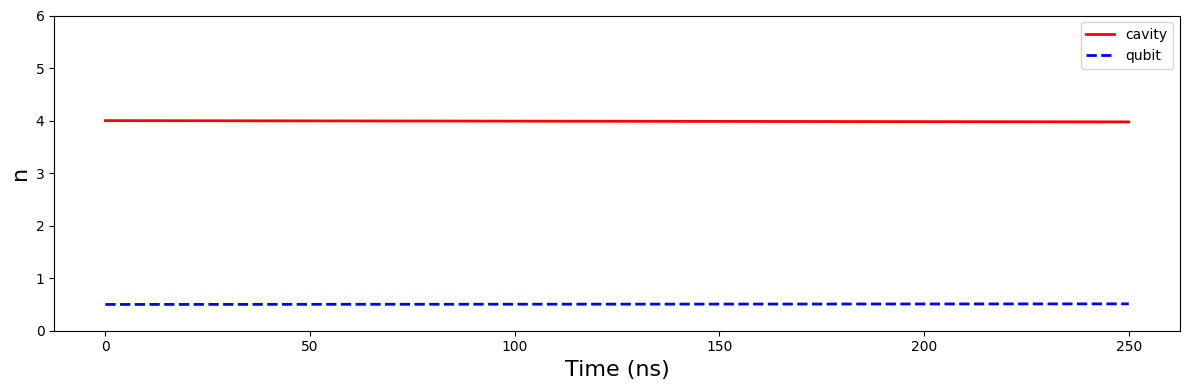

In [319]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, nc_list, 'r', linewidth=2, label="cavity")
ax.plot(tlist, nq_list, 'b--', linewidth=2, label="qubit")
ax.set_ylim(0, 6)
ax.set_ylabel("n", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()

fig.tight_layout()

## Resonator quadrature

However, the quadratures of the resonator are oscillating rapidly.


In [320]:
xc_list = expect(xc, res.states)

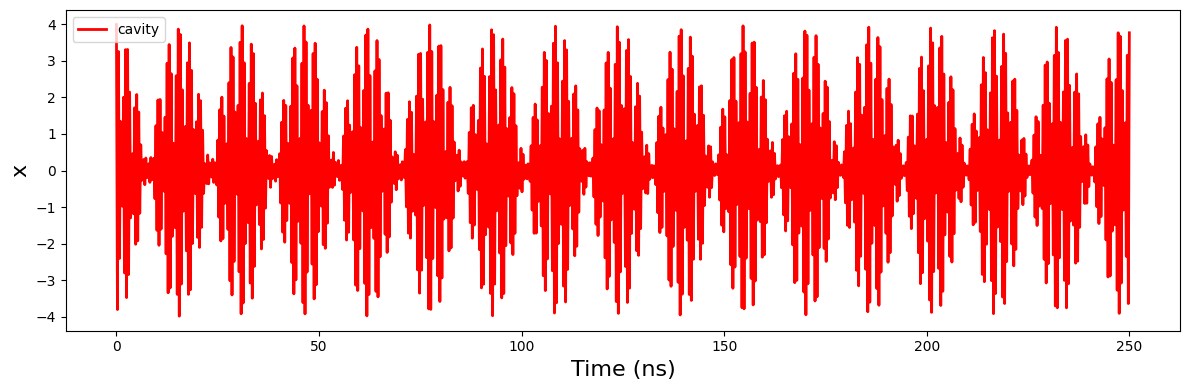

In [321]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, xc_list, 'r', linewidth=2, label="cavity")
ax.set_ylabel("x", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()

fig.tight_layout()

### Correlation function for the resonator

In [322]:
tlist = np.linspace(0, 1500, 50000)  

Calculate the two-operator two-time correlation function:
$\left<A(t+\tau)B(t)\right>$
along two time axes using the quantum regression theorem and the
evolution solver indicated by the `solver` parameter.

In [323]:
#corr_vec = correlation_2op_2t(H, psi0, None, tlist, [c_ops], a.dag(), a)   #, options=Odeoptions(nsteps=10000)
corr_vec = correlation_2op_2t(H, psi0, None, tlist, [], a.dag(), a)#, options=Odeoptions(nsteps=1000))  

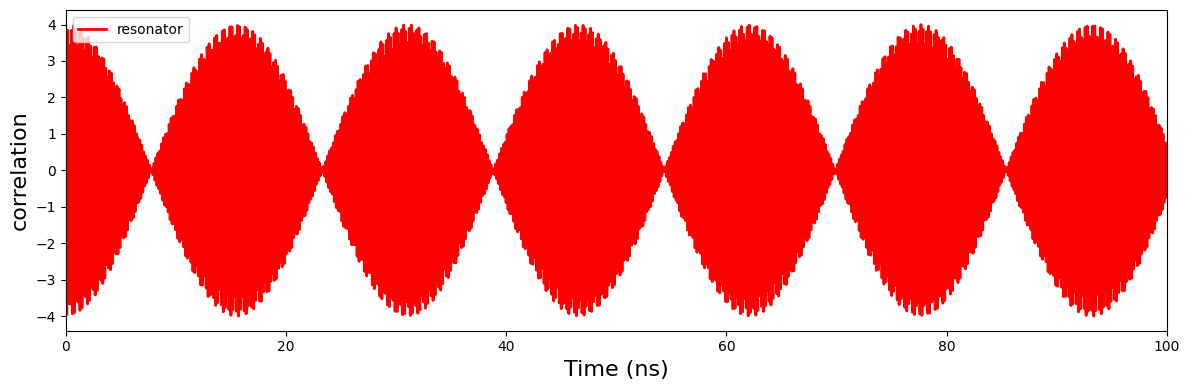

In [324]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, np.real(corr_vec), 'r', linewidth=2, label="resonator")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()
ax.set_xlim(0,100)
fig.tight_layout()

### Spectrum of the resonator

In [325]:
w, S = spectrum_correlation_fft(tlist, corr_vec)

(5.395386495646289, 6.204613504353711)

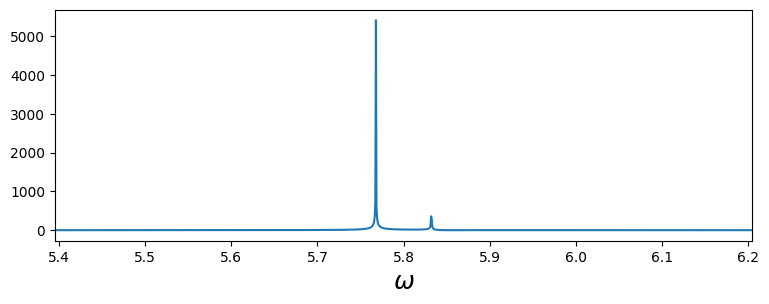

In [326]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(w/(2*np.pi), abs(S))
ax.set_xlabel(r'$\omega$', fontsize=18)
ax.set_xlim((wr)/(2*np.pi)-2*chi-2*mu, (wr)/(2*np.pi)+2*chi+2*mu)

Here we can see how the resonator peak is split and shiften up and down due to the superposition of 0 and 1 states of the qubit! We can also verify that the splitting is exactly $2(\chi+\mu)$, as expected:

(-2.0, 2.0)

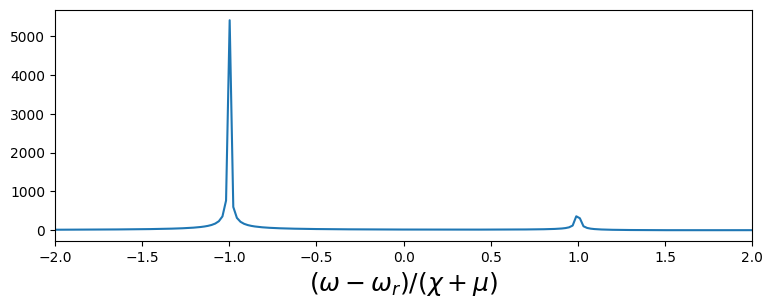

In [327]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot((w-wr)/(chi+mu), abs(S))
ax.set_xlabel(r'$(\omega-\omega_r)/(\chi+\mu)$', fontsize=18)
ax.set_xlim(-2,2)

Compare the resonator spectrum for the ground, excited and superpossition states f the qubit

In [328]:
S_s = S
S_g = []
S_e = []

psi0 = tensor(coherent(NN, np.sqrt(4)), basis(2,0))
corr_vec = correlation_2op_2t(H, psi0, None, tlist, [], a.dag(), a)
w, S_g = spectrum_correlation_fft(tlist, corr_vec)

psi0 = tensor(coherent(NN, np.sqrt(4)), basis(2,1))
corr_vec = correlation_2op_2t(H, psi0, None, tlist, [], a.dag(), a)
w, S_e = spectrum_correlation_fft(tlist, corr_vec)


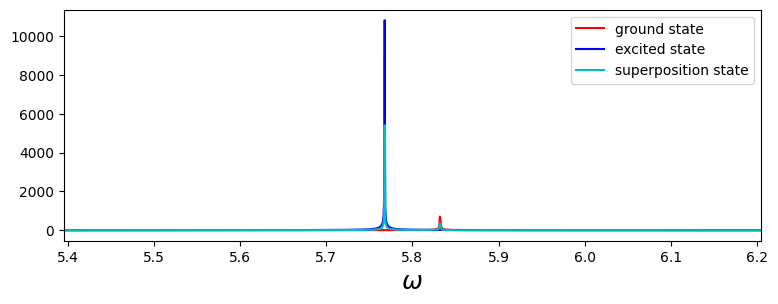

In [329]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(w/(2*np.pi), abs(S_g), 'r', label = 'ground state')
ax.plot(w/(2*np.pi), abs(S_e), 'b', label = 'excited state')
ax.plot(w/(2*np.pi), abs(S_s), 'c', label = 'superposition state')
ax.set_xlabel(r'$\omega$', fontsize=18)
ax.set_xlim((wr)/(2*np.pi)-2*chi-2*mu, (wr)/(2*np.pi)+2*chi+2*mu)
ax.legend()

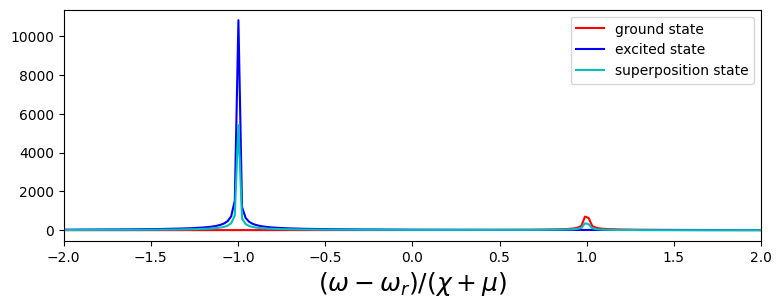

In [330]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot((w-wr)/(chi+mu), abs(S_g), 'r', label = 'ground state')
ax.plot((w-wr)/(chi+mu), abs(S_e), 'b', label = 'excited state')
ax.plot((w-wr)/(chi+mu), abs(S_s), 'c', label = 'superposition state')
ax.set_xlabel(r'$(\omega-\omega_r)/(\chi+\mu)$', fontsize=18)
ax.set_xlim(-2,2)
ax.legend()

### Correlation function of the qubit

In [331]:
corr_vec = correlation_2op_2t(H, psi0, None, tlist, [], sx, sx)#, options=Odeoptions(nsteps=10000))

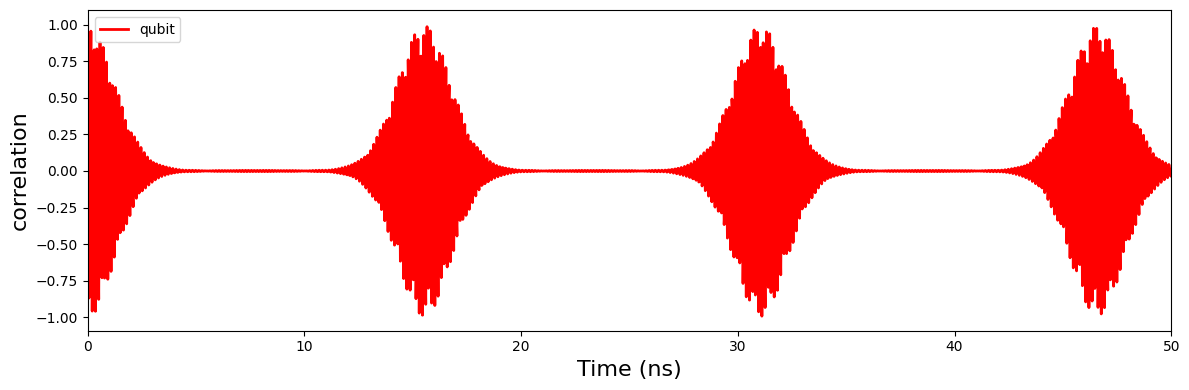

In [332]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, np.real(corr_vec), 'r', linewidth=2, label="qubit")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()
ax.set_xlim(0,50)
fig.tight_layout()

### Spectrum of the qubit

The spectrum of the qubit has an interesting structure: from it one can see the photon distribution in the resonator mode!

In [333]:
w, S = spectrum_correlation_fft(tlist, corr_vec)

Text(0.5, 0, '$\\omega$')

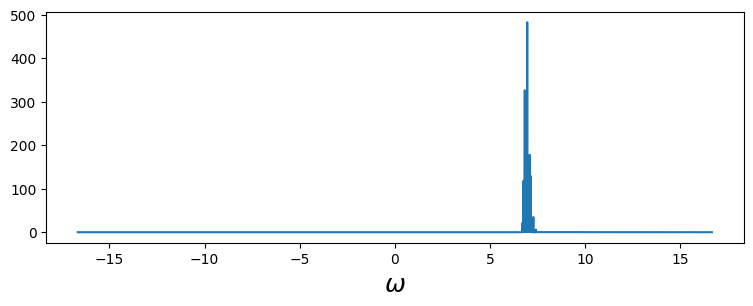

In [344]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(-w/ (2 * np.pi) , abs(S))
ax.set_xlabel(r'$\omega$', fontsize=18)

It's a bit clearer if we shift the spectrum and scale it with $2(\chi+\mu)$

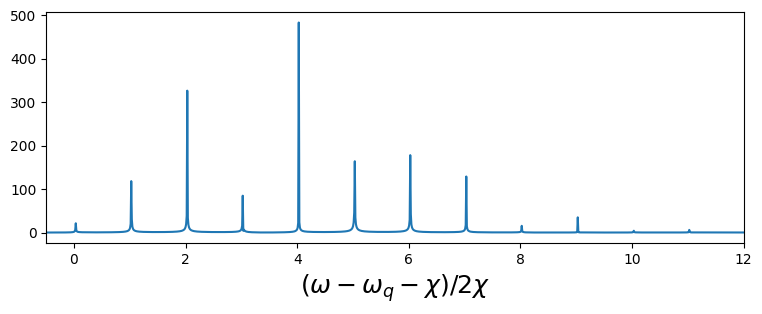

In [354]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(-(w + 6.732*2*np.pi - chi - mu) / (2 * (chi+mu)), abs(S))
ax.set_xlabel(r'$(\omega - \omega_q - \chi)/2\chi$', fontsize=18)
ax.set_xlim(-.5, NN);

Compare to the cavity fock state distribution:

In [336]:
rho_cavity = ptrace(res.states[-1], 0)

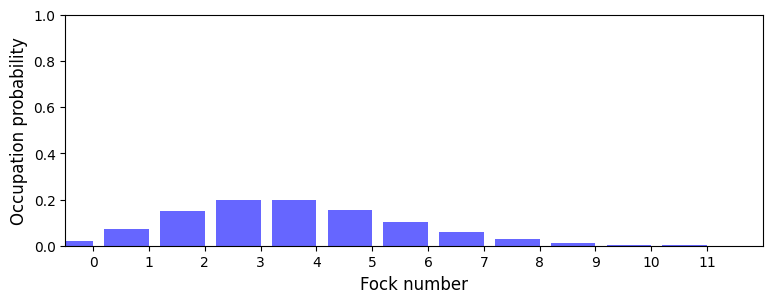

In [337]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(np.arange(0, NN)-.4, np.real(rho_cavity.diag()), color="blue", alpha=0.6)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, NN)
axes.set_xticks(np.arange(0, NN))
axes.set_xlabel('Fock number', fontsize=12)
axes.set_ylabel('Occupation probability', fontsize=12);

And if we look at the cavity wigner function we can see that after interacting dispersively with the qubit, the cavity is no longer in a coherent state, but in a superposition of coherent states.

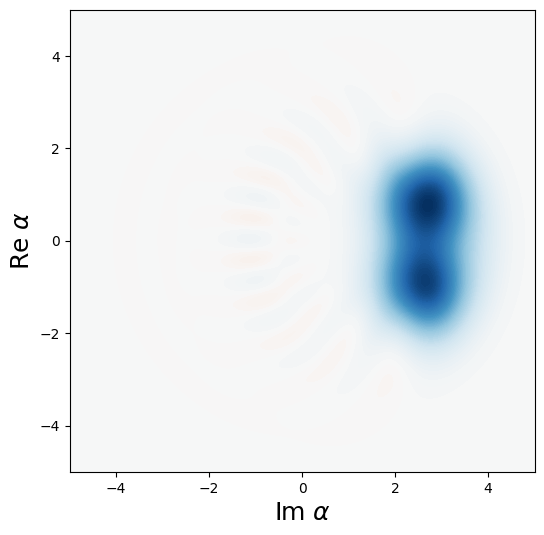

In [338]:
fig, axes = plt.subplots(1, 1, figsize=(6,6))

xvec = np.linspace(-5,5,200)
W = wigner(rho_cavity, xvec, xvec)
wlim = abs(W).max()

axes.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-wlim,wlim), cmap=plt.get_cmap('RdBu'))
axes.set_xlabel(r'Im $\alpha$', fontsize=18)
axes.set_ylabel(r'Re $\alpha$', fontsize=18);

In [172]:
def resonator_spectrum(g):
    chi = g**2/(wq - wr)
    mu  = g**2/(wq + wr)
    H = wr * (a.dag() * a + I/2.0) + (wq / 2.0) * sz + (chi+mu) * (a.dag() * a + I/2) * sz
    corr_vec = correlation_2op_2t(H, psi0, None, tlist, [], a.dag(), a)
    w, S = spectrum_correlation_fft(tlist, corr_vec)
    return w/(2*np.pi), abs(S)

In [186]:
g_list = np.linspace(0, 5*2*np.pi, 100) 
S_all = np.zeros((np.size(g_list),np.size(tlist)), dtype=float)

In [188]:
f = IntProgress(min=0, max=np.size(g_list)) # instantiate the bar
display(f) # display the bar

for g_id, g_value in enumerate(g_list):
    w, S_all[g_id] = resonator_spectrum(g_value)
    f.value += 1

IntProgress(value=0)

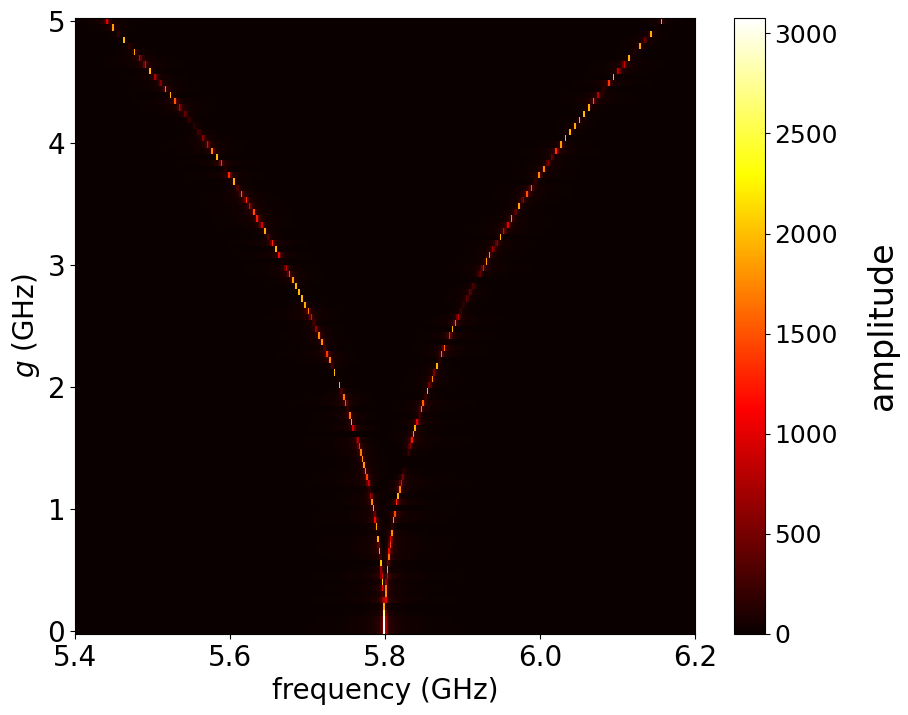

In [193]:
#hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,1,figsize = (10, 8))
p = axes.pcolor(w, g_list/2/np.pi, S_all, cmap = cm.hot, shading='auto')
axes.tick_params(axis ='x', labelsize = 20)
axes.tick_params(axis ='y', labelsize = 20)
axes.set_xlabel(r'frequency (GHz)', fontsize=20)
axes.set_ylabel(r'$g$ (GHz)', fontsize = 20)
axes.set_xlim((5.40, 6.2))
#axes.set_ylim((0, 0.015))
cb = fig.colorbar(p, ax = axes)
cb.set_label(r'amplitude', labelpad = 20, rotation = 90, fontsize = 24)
cb.ax.tick_params(labelsize = 18)
#ymin, ymax = axes.get_ylim()
#axes.set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
#xmin, xmax = axes.get_xlim()
#axes.set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))

#plt.plot(0.03575*6, 0.17, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
#plt.plot(0.03575*5.8, 0.03, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green")

plt.gcf().set_size_inches(10,8)
plt.savefig("C:/Users/Kirill/Desktop/BS+dispersive shifts.png", bbox_inches="tight")

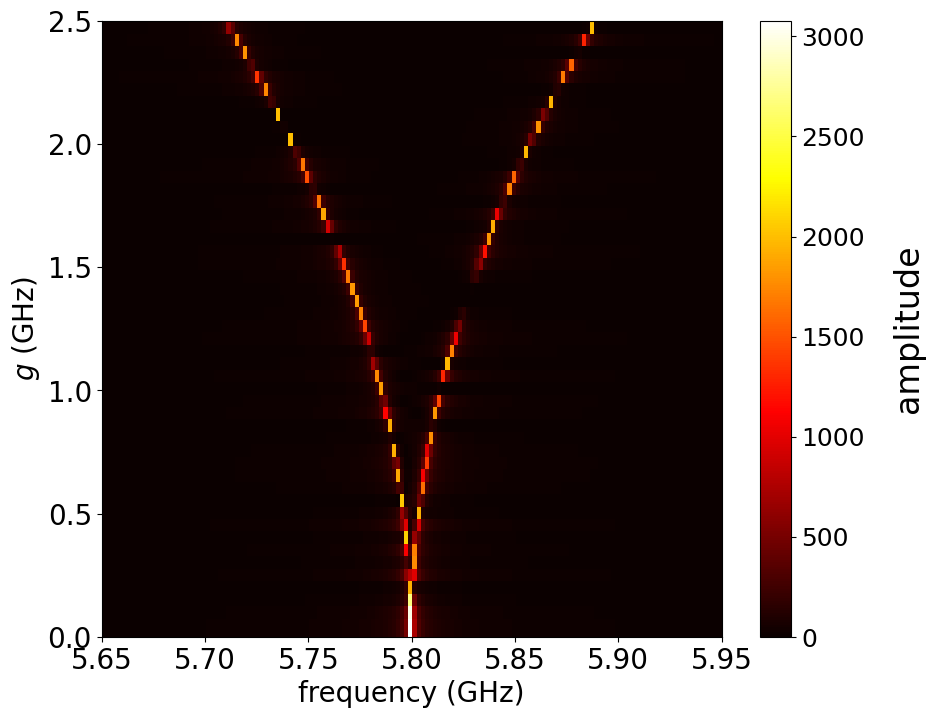

In [195]:
#hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,1,figsize = (10, 8))
p = axes.pcolor(w, g_list/2/np.pi, S_all, cmap = cm.hot, shading='auto')
axes.tick_params(axis ='x', labelsize = 20)
axes.tick_params(axis ='y', labelsize = 20)
axes.set_xlabel(r'frequency (GHz)', fontsize=20)
axes.set_ylabel(r'$g$ (GHz)', fontsize = 20)
axes.set_xlim((5.65, 5.95))
axes.set_ylim((0, 2.5))
cb = fig.colorbar(p, ax = axes)
cb.set_label(r'amplitude', labelpad = 20, rotation = 90, fontsize = 24)
cb.ax.tick_params(labelsize = 18)
#ymin, ymax = axes.get_ylim()
#axes.set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
#xmin, xmax = axes.get_xlim()
#axes.set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))

#plt.plot(0.03575*6, 0.17, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
#plt.plot(0.03575*5.8, 0.03, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green")

plt.gcf().set_size_inches(10,8)
plt.savefig("C:/Users/Kirill/Desktop/BS+dispersive shifts_small.png", bbox_inches="tight")

A more fundamental limitation for any cavity QED experiment arises from the second order mixture of the atomic and photonic states, creating a probability, $(g/\Delta)^2$ , that a measurement of photon number will absorb a photon or a measurement of the atomic state will induce a transition, demolishing the measured state.

In [28]:
Demo_rate = g**2/delta**2
print('Demolition rate:', Demo_rate*100, '%')

Demolition rate: 0.0124933091388834 %


Critical number of photons inside the Landau resonator

In [147]:
Crit_N = (delta/2/g)**2
print('Critical number of photons:', Crit_N)

Critical number of photons: 285675.7977874379
